<a href="https://colab.research.google.com/github/decorouz/DeepLeaning-with-Tensorflow/blob/main/3_0_Predicting_housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.0 Predicting house prices: a regression example

This involves predicting continous value instead of discrete label: for instance, predicting the temperature tomorrow, given meteorological data.

The goal is to attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, givent the data points about the suburb at the time.

### 3.1 The Boston Housing Price dataset

The dataset have few datapoints: only 506, plit between 404 training samples and 102 test samples. Each feature in the input data has different scale.



####3.11 Loading the Boston housing dataset

In [53]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [54]:
# look at the data
print(f"The shape of the training data is {train_data.shape}")
print(f"The shape of the testing data set is {test_data.shape} ")

The shape of the training data is (404, 13)
The shape of the testing data set is (102, 13) 


In [55]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

#### 3.12 Preparing the data

It would be problematic to feed into a neural network values that all take wildly different
ranges. A widespread best practice to deal with such data is sto do feature-wise normalization.

In [56]:
# Normalizing the data

mean = train_data.mean(axis=0)
std = test_data.std(axis=0)

def normalize(data):
  data -= mean
  data /= std

  return data

train_data = normalize(train_data)
test_data = normalize(test_data)

In [57]:
train_data.shape

(404, 13)

### 3.2 Building the network

Because only few samples are available. we will use a very small network with two hidden laters, eachwith 64 units.


In [58]:
# Model definition
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dense(1))

  # compile the model
  model.compile(optimizer="rmsprop",
                loss="mse",
                metrics=["mae"])
  
  return model

Mean absolute error (MAE) is metric to monitor. The absolute value of the difference between the predictions and thetargets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average

#### 3.14 Validation Approach using K-Fold validation.

In cases of limited data, splitting the training data into validation and train will result in high variance. That is the validation score might change a lot depending on which data point you chose to use for validation and which you chose for training. 

Therefore an approach such as K-fold validation is best practice. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating
K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained. In terms of code, this is straightforward.

In [59]:
# K-fold validation

import numpy as np


k = 4
num_val_samples  = len(train_data) // k
num_epochs = 100
all_scores = []


for i in range(k):
  print("Processing fold #", i)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]       # prepare the validation data: data from partition #k
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples] # prepare the training data: data from all other partitions

  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                       train_data[(i+1) * num_val_samples:]],
                                      axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                          train_targets[(i + 1) * num_val_samples:]],
                                         axis=0)
  
  model = build_model()                                                   # Build the Keras model
  model.fit(partial_train_data,
            partial_train_targets,
            epochs=num_epochs,
            batch_size=1,
            verbose=0)
  
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)




Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [8]:
#Running this with num_epochs=100 yields
print(all_scores)
np.mean(all_scores)

[2.1776113510131836, 2.665213108062744, 2.768186569213867, 2.7034518718719482]


2.578615725040436

The different run do indeed show rather different validation scores, from 2.0 - 2.5. The average (2.3) is much more reliable than any single score- that is the entire point of the k-fold cross-validation.

In this case, you're off by `$2300` on average, which issignificant considering the prices of house range from `$10,000 to $50,000`.

Let's try training the network a bit longer: 500 epochs.

In [9]:
# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []

for i in range(k):
  print("Processing fold #", i)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]       # prepare the validation data: data from partition #k
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples] # prepare the training data: data from all other partitions

  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                       train_data[(i+1) * num_val_samples:]],
                                      axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                          train_targets[(i + 1) * num_val_samples:]],
                                         axis=0)
  
  model = build_model()                                                   # Build the Keras model
  history = model.fit(partial_train_data,
                      partial_train_targets,
                      epochs=num_epochs,
                      batch_size=1,
                      validation_data=(val_data,val_targets),
                      verbose=0)
  mae_history = history.history["val_mae"]
  all_mae_histories.append(mae_history)



Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [ ]:
# Building the history of successive mean K-fold validation scores
# Compute the average of the per-epoch MAE score for all folds.

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

### 3.5 Plotting The figures

####3.51 Plotting the validation scores

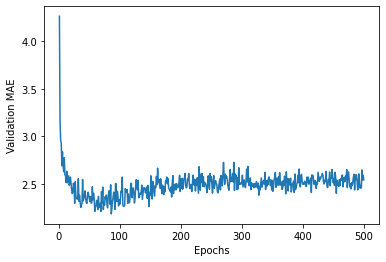

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


It is a litle difficult to see the plot, due to high variance and scaling issues. Do the following to correct:
* Omit the first 10 data points, which are on a different scale than the rest of the curve. 
* Replace each point with an exponential moving average of the previous points to obtain a smooth curve

####3.52 Plotting validation scores, excluding the first 10 data points.

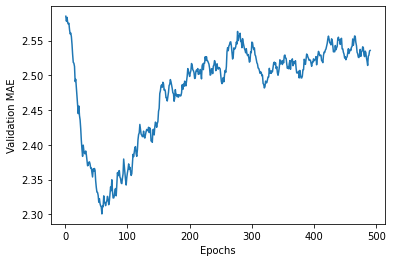

In [46]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


According to this plot, validation MAE stops improving after 80 epochs. Pass that point, you start overfitting.

###3.6 Training the final model.
After turning other parameters, like the hidden layers and the number of epochs.

In [51]:
model = build_model()
model.fit(train_data,
          train_targets, 
          epochs=80,
          batch_size=16,
          verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targest)

4/4 [==============================] - 0s 5ms/step - loss: 17.9893 - mae: 2.6119


In [52]:
test_mae_score

2.6119072437286377

Still off by `$2600`

(4,)